# Experiment 2. Apply MLReal to inputs only
 
This notebook accompanies experiment for low-frequency extrapolation using MLReal pre-processing approach from [Alkhalifah, Wang and Ovcharenko, 2021](https://arxiv.org/abs/2109.05294). 
 The [network](https://github.com/ovcharenkoo/mtl_low) learns mapping between high-frequency data (> 4 Hz) and low-frequency data (< 5 Hz) where synthetic and field data **inputs are transformed using MLReal** method while **targets are unmodified** synthetic.

**Takeaway:** Transformed inputs from synthetic and fields datasets get alike which confuses training so the inference on field data suffers from assumpotions introduced in synthetic data, such as lack of attenuation and missing 3D effects.   

In [1]:
# Most imports are in the shared_data_loading.ipynb
import os

# This is to prevent the error "this loop already running when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Constrain visibility of GPUs by selected one. This is to enable training of multiple networks each on its own device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# Where to save the trained model
root_pretrained = os.path.join('./pretrained_files/trained_nets/ex2_mlreal_forw/')
root_out = os.path.join('./pretrained_files/trained_nets/ex2_mlreal_forw/')

## Load data

1.8.1+cu102
3.8.3 (default, Oct 11 2020, 17:10:44) 
[GCC 7.5.0]
/home/ovcharoo/work/env_torch
{'high': {'flo': 4, 'btype': 'high', 'order': 8}, 'low': {'fhi': 5, 'btype': 'low', 'order': 8}, 'ulow': {'fhi': 2.5, 'btype': 'low', 'order': 8}}


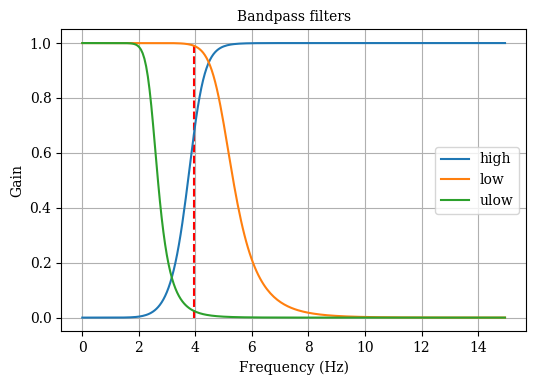

Load cubes from ./pretrained_files/data/syn_1024_el/...
(2765, 324, 376) (2765, 324, 376) (2765, 324, 376) (2765, 324, 376)
(154, 324, 376) (154, 324, 376) (154, 324, 376) (154, 324, 376)
(64, 324, 376) (64, 324, 376) (64, 324, 376) (64, 324, 376)
(64, 324, 376) (64, 324, 376) (64, 324, 376) (64, 324, 376)
Processed data loaders: 2765 154
Load ./pretrained_files/data/noise_donors/cube_dst_te_h.npy
(80, 324, 376)
(80, 324, 446)
8


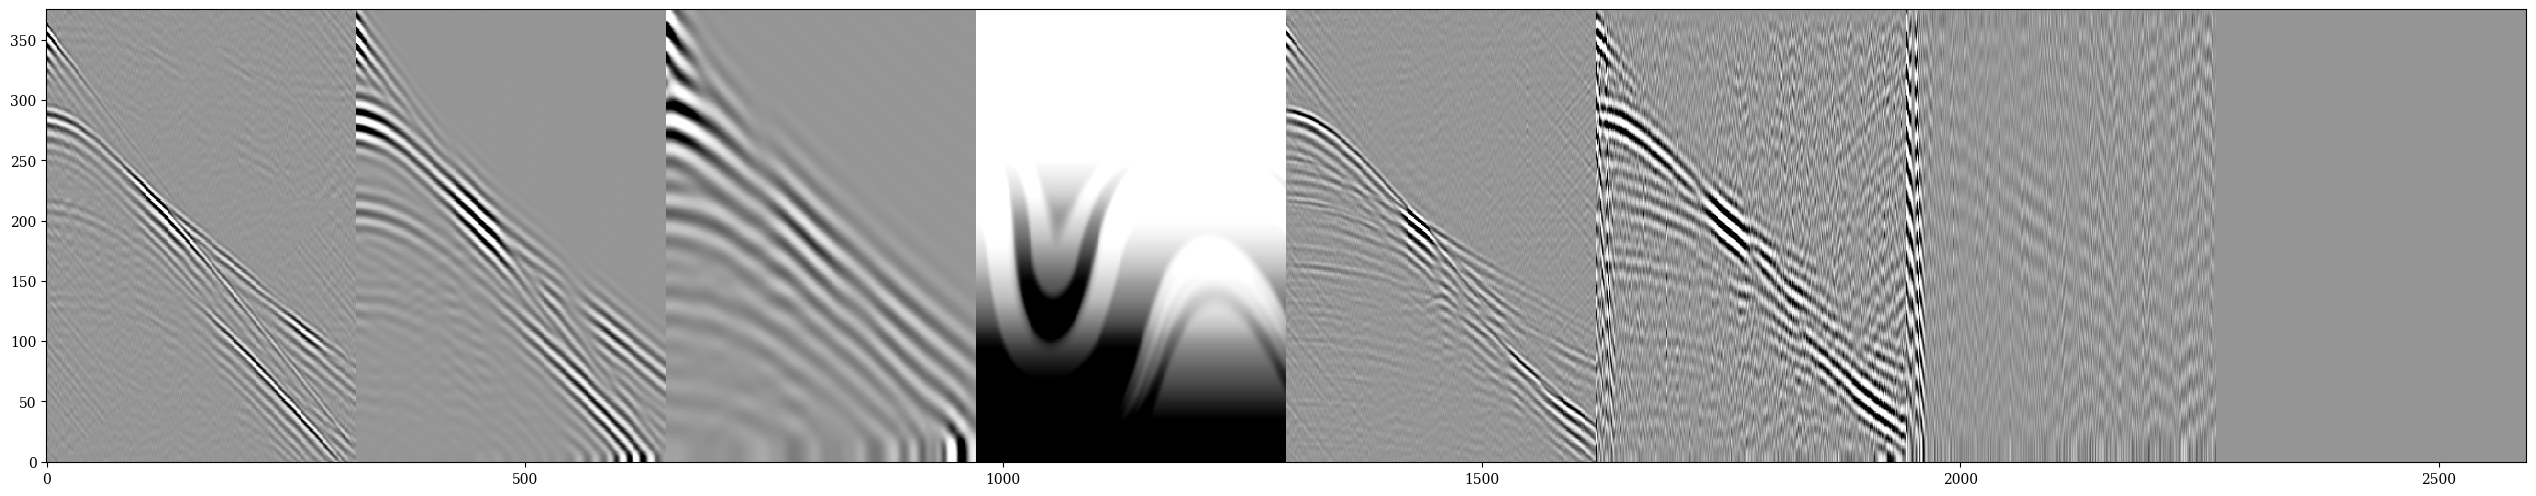

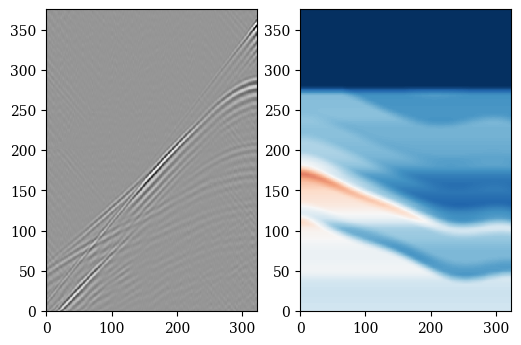

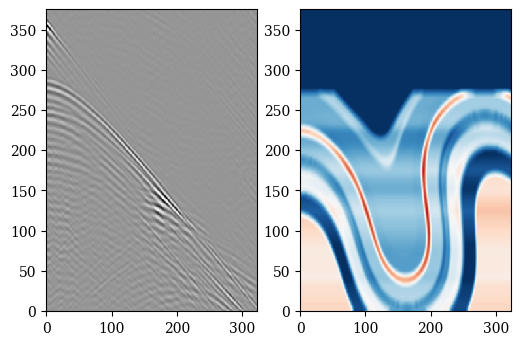

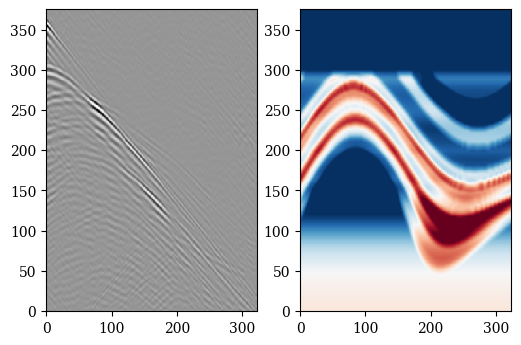

In [4]:
%run shared_data_loading.ipynb

# Direct Domain Adaptation (DDA)

In [5]:
def forward(data, trace, glob_acorr):
    # Data for xcorr with trace
    y = np.squeeze(data)
    ffty = np.fft.fftshift(np.fft.rfft(y, n=y.shape[-1], axis=1))

    # Trace
    no, nt = y.shape
    _trace = np.repeat(trace, no, 0)
    fft_trace = np.fft.fftshift(np.fft.rfft(_trace, n=_trace.shape[-1], axis=-1))

    # xcorr data x trace
    xcorr = ffty * np.conjugate(fft_trace)

    # Convolution of acorr and xcorr data
    conv = xcorr * glob_acorr

    # Freq -> time domain
    rr = np.fft.irfft(np.fft.ifftshift(conv), axis=-1)
#     return np.expand_dims(rr, 0).astype(np.float64)
    return np.expand_dims(rr, 0).astype(np.float32)

def backward(data, trace, glob_acorr, eps=1e0):
    # Data for xcorr with trace
    y = np.squeeze(data)
    ffty = np.fft.fftshift(np.fft.rfft(y, n=y.shape[-1], axis=-1))

    # Trace
    no, nt = y.shape
    _trace = np.repeat(trace, no, 0)
    fft_trace = np.fft.fftshift(np.fft.rfft(_trace, n=_trace.shape[-1], axis=-1))
    
    deconv =  (ffty * np.conjugate(glob_acorr)) / (glob_acorr * np.conjugate(glob_acorr) + eps)

    out = (fft_trace * deconv) / (fft_trace * np.conjugate(fft_trace) + eps)

    # Freq -> time domain
    rr = np.fft.irfft(np.fft.ifftshift(out), axis=-1)
    return np.expand_dims(rr, 0).astype(np.float32)

## Train loader

In [6]:
class CorrLoader(torch.utils.data.Dataset):
    def __init__(self, l1, rcorr_indices=None, acorr_indices=None, reference_traces=None):
        super().__init__()
        self.l1 = l1
        self.acorr_indices = acorr_indices
        self.rcorr_indices = rcorr_indices
        self.reference_traces = reference_traces
            
    def __len__(self):
        return len(self.l1)
        
    def __getitem__(self, item):
        list_data = list(self.l1.__getitem__(item))
        
        random_index = np.random.randint(0, len(self.l1))
        another_list_data = list(self.l1.__getitem__(random_index))
        
        for i in range(len(self.acorr_indices)):
            # Data for autocorrelation
            x = np.squeeze(another_list_data[self.acorr_indices[i]])
            fftx = np.fft.fftshift(np.fft.rfft(x, n=x.shape[-1], axis=-1))
            acorr = fftx * np.conjugate(fftx)
            
            rr = forward(list_data[self.rcorr_indices[i]], 
                         **{'trace': self.reference_traces[i], 'glob_acorr': acorr})
            
            # Append the transformed data to the end of the data vector
            list_data.append(rr)
        return list_data
    
idx = 600
# Take 4th trace of synthetic high-frequency data (index 0)
reference_trace = jloader_te.__getitem__(idx)[0][0, 4:5, :]
reference_trace_target = jloader_te.__getitem__(idx)[1][0, 4:5, :]

reference_trace_f = jloader_te.__getitem__(idx)[4][0, 4:5, :]
reference_trace_target_f = jloader_te.__getitem__(idx)[5][0, 4:5, :]

In [7]:
par_loader_corr = {'reference_traces': [reference_trace], 
                   'rcorr_indices': [0], # high and low synthetic
                   'acorr_indices': [4]} # high and low field

cloader_tr = CorrLoader(jloader_tr, **par_loader_corr)

## Test loader

In [8]:
class CorrLoaderTest(torch.utils.data.Dataset):
    def __init__(self, l1, rcorr_indices, acorr_indices, reference_traces, glob_acorr):
        super().__init__()
        self.l1 = l1
        self.acorr_indices = acorr_indices
        self.rcorr_indices = rcorr_indices
        self.reference_traces = reference_traces
        self.glob_acorr = glob_acorr
            
    def __len__(self):
        return len(self.l1)
        
    def __getitem__(self, item):
        list_data = list(self.l1.__getitem__(item))
        
        for i in range(len(self.acorr_indices)):   
            rr = forward(list_data[self.rcorr_indices[i]], 
                         **{'trace': self.reference_traces[i], 
                          'glob_acorr': self.glob_acorr[i]})
            
            # Append the transformed data to the end of the data vector
            list_data.append(rr)

        return list_data

### Global auto-correlation

In [9]:
def get_global_acorr_for_loader(loader, index):
    """ The average auto-correlation of all images in the dataset """
    global_acorr = np.zeros((1,324,189), dtype=np.complex128)
    len_loader = len(loader)
    for idata in range(len_loader):
        print(f'{idata+1}/{len_loader}', end='\r')
        data = loader.__getitem__(idata)
        data_f = np.fft.fftshift(np.fft.rfft(data[index], n=data[index].shape[-1], axis=-1))
        # Auto-correlation is multiplication with the conjucate of self
        # in frequency domain
        global_acorr += data_f * np.conjugate(data_f)
    global_acorr /= len_loader
    print(global_acorr.shape)
    return np.squeeze(global_acorr)

def route_to(fname):
    """ Shortcut for routing to the save folder """
    return os.path.join(root_out, fname)

# Compute global acorr if not in the folder, load otherwise
os.makedirs(root_out, exist_ok=True)
if not 'gacorr_hi.npy' in os.listdir(root_out):
    print('Save global acorr')
    gacorr_hi = get_global_acorr_for_loader(jloader_tr, index=0)
    gacorr_lo = get_global_acorr_for_loader(jloader_tr, index=1)
    gacorr_hi_f = get_global_acorr_for_loader(jloader_tr, index=4)
    gacorr_lo_f = get_global_acorr_for_loader(jloader_tr, index=5)
    np.save(route_to('gacorr_hi.npy'), gacorr_hi)
    np.save(route_to('gacorr_lo.npy'), gacorr_lo)
    np.save(route_to('gacorr_hi_f.npy'), gacorr_hi_f)
    np.save(route_to('gacorr_lo_f.npy'), gacorr_lo_f)
else:
    print('Load global acorr')
    gacorr_hi = np.load(route_to('gacorr_hi.npy'))
    gacorr_lo = np.load(route_to('gacorr_lo.npy'))
    gacorr_hi_f = np.load(route_to('gacorr_hi_f.npy'))
    gacorr_lo_f = np.load(route_to('gacorr_lo_f.npy'))

Load global acorr


In [10]:
cloader_te = CorrLoaderTest(jloader_te, 
                           reference_traces=[reference_trace],
                           rcorr_indices=[0],
                           acorr_indices=[4],
                           glob_acorr=[gacorr_hi_f, gacorr_lo_f])
cloader_te_f = CorrLoaderTest(jloader_te, 
                        reference_traces=[reference_trace_f], 
                        rcorr_indices=[4],  # high and low field
                        acorr_indices=[0],
                        glob_acorr=[gacorr_hi])  

## Explore data

In [11]:
idx = 41
# Original loader
d = jloader_te.__getitem__(idx)
# Training loader (synthetic data normalized)
dc = cloader_te.__getitem__(idx)
# Inference loader (field data normalized)
df = cloader_te_f.__getitem__(idx)

In [12]:
# dff = cloader_tr.__getitem__(idx)
# vis.plot_shot(np.concatenate([dff[i][0,...] for i in [-1, 1]]), **_par_shot_auto_norm, title='Input / Target')

### Synthetic

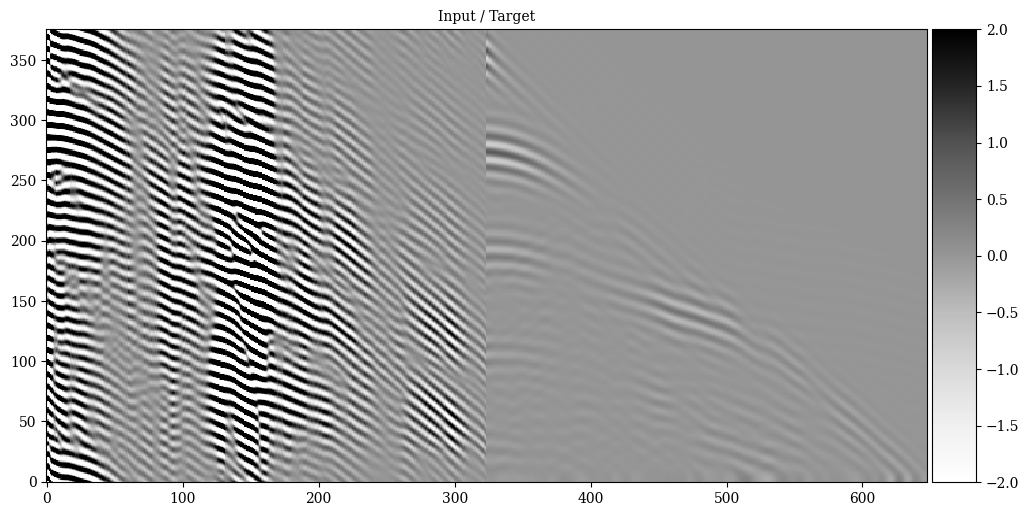

In [13]:
par_shot_auto = {'vmax': 0.25, 'vmin': -0.25}
_par_shot_auto = copy.copy(par_shot_auto)
_par_shot_auto['figsize'] = (12, 6)
_par_shot_auto_norm = copy.copy(_par_shot_auto)
_par_shot_auto_norm['vmin'] = -2
_par_shot_auto_norm['vmax'] = 2

# Input is pre-last, target is last
vis.plot_shot(np.concatenate([dc[i][0,...] for i in [-1, 1]]), **_par_shot_auto_norm, title='Input / Target')

## Forward and backward DDA

(1, 324, 376) (1, 324, 376)


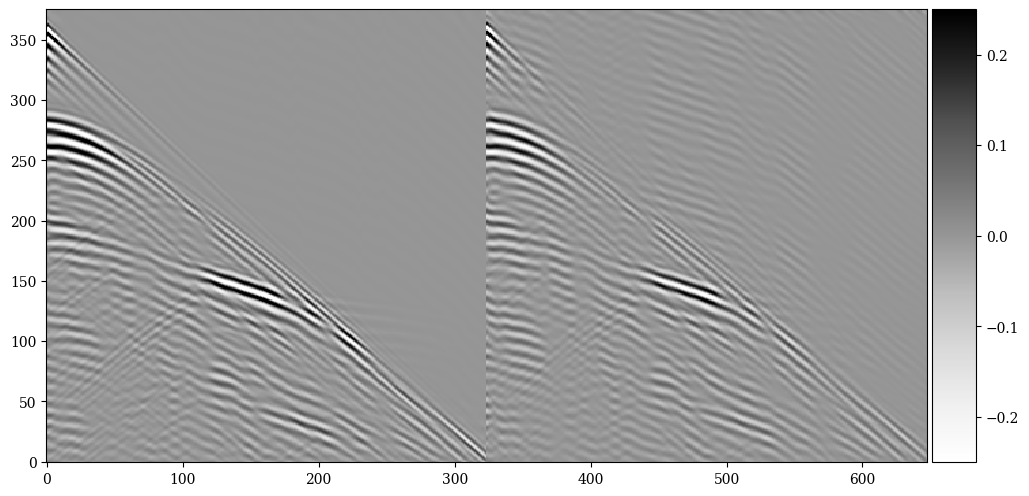

In [14]:
par_forw_back_h = {'trace': reference_trace, 
                 'glob_acorr': gacorr_hi_f}

dc_h_inv = backward(forward(d[0], **par_forw_back_h), **par_forw_back_h) 
print(d[0].shape, dc_h_inv.shape)
vis.plot_shot(np.concatenate([np.squeeze(d[0]), np.squeeze(dc_h_inv)], 0), **_par_shot_auto)

### Field

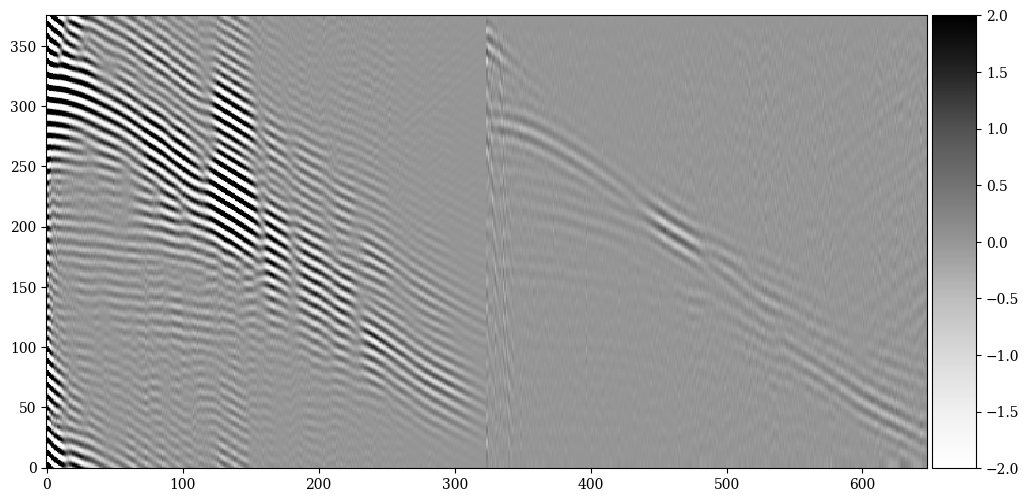

In [15]:
vis.plot_shot(np.concatenate([df[i][0,...] for i in [-1, 5]]), **_par_shot_auto_norm)
# plt.figure(); plt.plot(reference_trace_f.T, color='k'); plt.title('Reference trace from high-frequency synthetic');

## Syn VS Field

### Shots

Input before RMS:	[0.04274155101897403, 0.04107810967665637]
Input after RMS:	[3.016962242092659, 1.1906231934683877]
Target before RMS:	[0.07554600545604165, 0.08275974693024492]


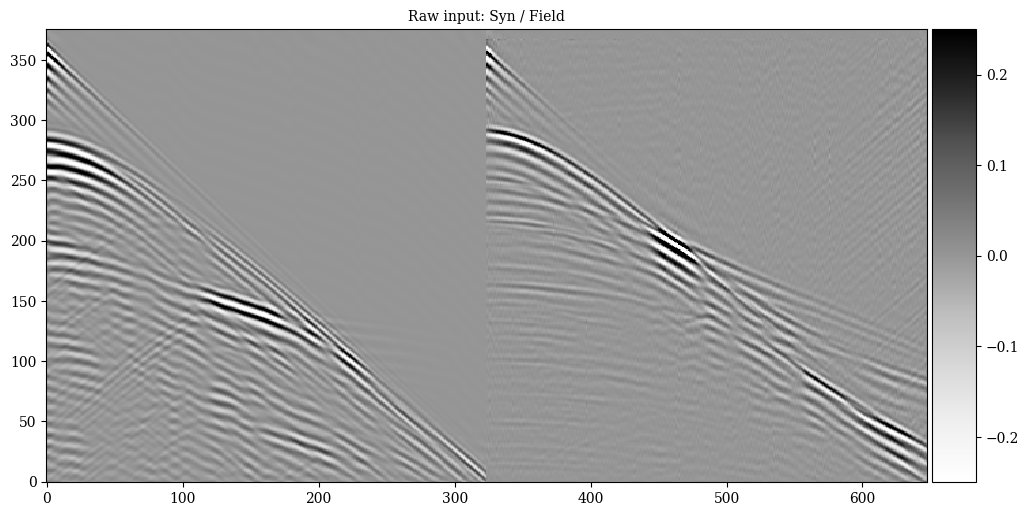

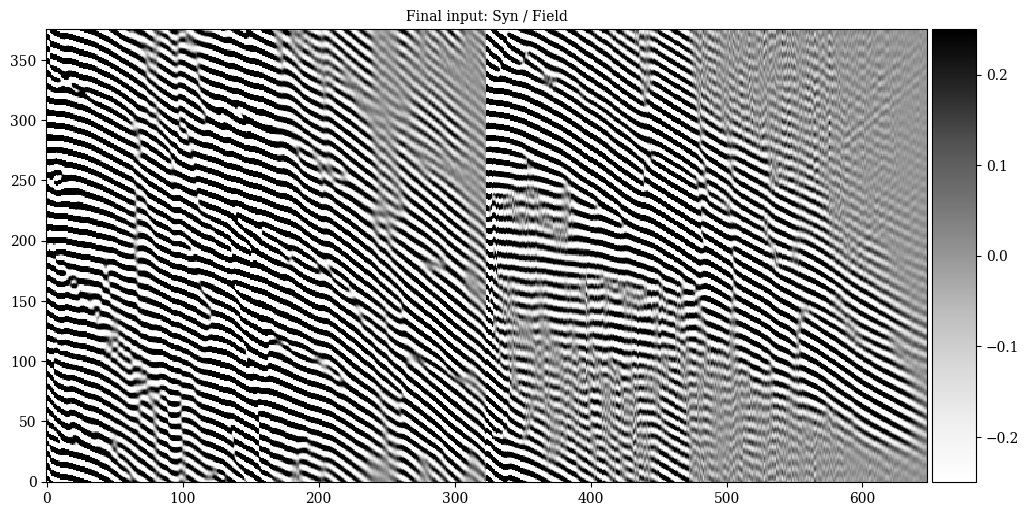

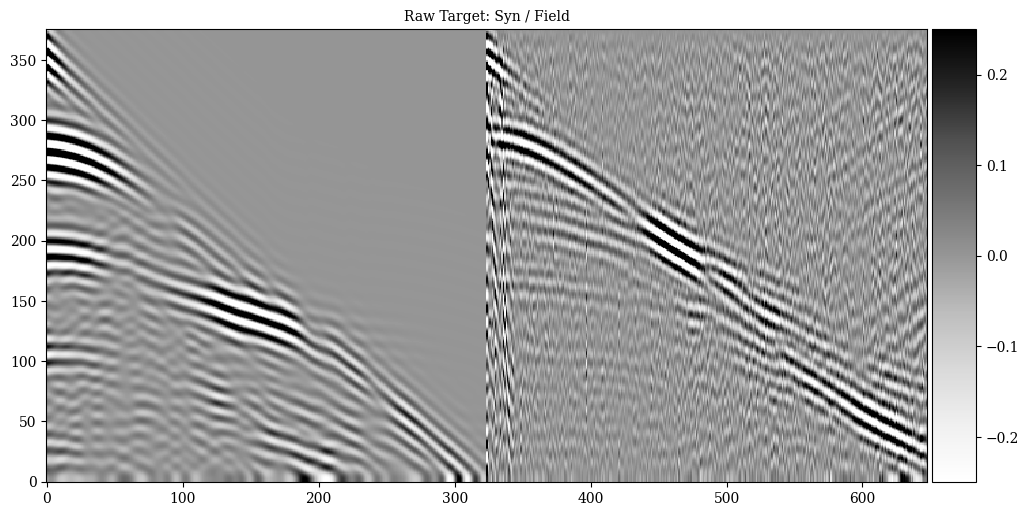

In [16]:
datas = [d[0], d[4]]
print(f'Input before RMS:\t{[vis.rms(_d) for _d in datas]}')
vis.plot_shot(np.concatenate([_d[0,...] for _d in datas]), title='Raw input: Syn / Field', **_par_shot_auto)

datas = [dc[-1], df[-1]]
print(f'Input after RMS:\t{[vis.rms(_d) for _d in datas]}')
vis.plot_shot(np.concatenate([_d[0,...] for _d in datas]), title='Final input: Syn / Field', **_par_shot_auto)

datas = [d[1], d[5]]
print(f'Target before RMS:\t{[vis.rms(_d) for _d in datas]}')
vis.plot_shot(np.concatenate([_d[0,...] for _d in datas]), title='Raw Target: Syn / Field', **_par_shot_auto)

# Multi-column architecture
Based on https://github.com/shepnerd/inpainting_gmcnn

In [17]:
# Low-frequency data head (L)
import torch.nn as nn

class HeadData(nn.Module):
    def __init__(self, layers, layers_out, kernel_sizes, strides, pads):
        super().__init__()
        self.act = F.leaky_relu
        self.decoding_layers = []
        
        # Upscale to the target size
        for ilayer, (ch_inp, ch_out) in enumerate(layers):
            self.decoding_layers.append(nn.ConvTranspose2d(ch_inp, ch_out, 
                                                            kernel_size=kernel_sizes[ilayer], 
                                                            stride=strides[ilayer],
                                                            padding=pads[ilayer]))
            self.decoding_layers.append(nn.LeakyReLU())
        
        # After reaching the target size, do this
        self.out_layers = []
        self.out_layers.append(nn.Conv2d(layers_out[0], layers_out[0], kernel_size=3, padding=1))
        self.out_layers.append(nn.Conv2d(layers_out[0], layers_out[1],kernel_size=1))
        
        # Convert to Pytorch modules
        self.decoding_layers = nn.ModuleList(self.decoding_layers)
        self.out_layers = nn.ModuleList(self.out_layers)
        
    def forward(self, x):
        for layer in self.decoding_layers:
            x = layer(x)
        for layer in self.out_layers:
            x = layer(x)
        return x #torch.clip(x, -1, 1)

# Encoder
# Based on https://github.com/shepnerd/inpainting_gmcnn
class Encoder(nn.Module):
    def __init__(self, n_channels, kernel_size=3, bilinear=True, s=2, ch=8):
        super().__init__()
        self.using_norm = True
        self.norm = F.instance_norm
        self.act = F.leaky_relu
        
        # network structure
        self.EB1 = []
        self.EB1_pad_rec = [3, 3, 3, 3, 3, 3, 6, 12, 24, 48, 3, 3, 0]
        self.EB1.append(nn.Conv2d(n_channels, ch, kernel_size=7, stride=1))
        self.EB1.append(nn.Conv2d(ch, ch * 2, kernel_size=7, stride=2))
        self.EB1.append(nn.Conv2d(ch * 2, ch * 2, kernel_size=7, stride=1))
        self.EB1.append(nn.Conv2d(ch * 2, ch * 4, kernel_size=7, stride=2))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1, dilation=2))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1, dilation=4))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1, dilation=8))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1, dilation=16))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1))
        self.EB1.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=7, stride=1))
        self.EB1 = nn.ModuleList(self.EB1)
        
        self.EB2 = []
        self.EB2_pad_rec = [2, 2, 2, 2, 2, 2, 4, 8, 16, 32, 2, 2, 0, 2, 2, 0]
        self.EB2.append(nn.Conv2d(n_channels, ch, kernel_size=5, stride=1))
        self.EB2.append(nn.Conv2d(ch, ch * 2, kernel_size=5, stride=2))
        self.EB2.append(nn.Conv2d(ch * 2, ch * 2, kernel_size=5, stride=1))
        self.EB2.append(nn.Conv2d(ch * 2, ch * 4, kernel_size=5, stride=2))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1, dilation=2))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1, dilation=4))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1, dilation=8))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1, dilation=16))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1))
        self.EB2.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=5, stride=1))
        self.EB2 = nn.ModuleList(self.EB2)
        
        self.EB3 = []
        self.EB3_pad_rec = [1, 1, 1, 1, 1, 1, 2, 4, 8, 16, 1, 1, 0, 1, 1, 0, 1, 1]
        self.EB3.append(nn.Conv2d(n_channels, ch, kernel_size=3, stride=1))
        self.EB3.append(nn.Conv2d(ch, ch * 2, kernel_size=3, stride=2))
        self.EB3.append(nn.Conv2d(ch * 2, ch * 2, kernel_size=3, stride=1))
        self.EB3.append(nn.Conv2d(ch * 2, ch * 4, kernel_size=3, stride=2))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1, dilation=2))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1, dilation=4))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1, dilation=8))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1, dilation=16))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1))
        self.EB3.append(nn.Conv2d(ch * 4, ch * 4, kernel_size=3, stride=1))
        self.EB3 = nn.ModuleList(self.EB3)
        
        self.decoding_pad_rec = [1, 1]
        self.decoding_layers = []
        
        self.decoding_layers.append(nn.Conv2d(96, 96, kernel_size=3, stride=1))
        self.decoding_layers.append(nn.Conv2d(96, 96, kernel_size=3, stride=1))
        self.decoding_layers = nn.ModuleList(self.decoding_layers)
        
        # padding operations
        padlen = 49
        self.pads = [0] * padlen
        for i in range(padlen):
            self.pads[i] = nn.ReflectionPad2d(i)
        self.pads = nn.ModuleList(self.pads)
    
    def forward(self, x):
        x1, x2, x3 = x, x, x
        
        for i, layer in enumerate(self.EB1):
            pad_idx = self.EB1_pad_rec[i]
            x1 = layer(self.pads[pad_idx](x1))
            if self.using_norm:
                x1 = self.norm(x1)
            if pad_idx != 0:
                x1 = self.act(x1)
                
        for i, layer in enumerate(self.EB2):
            pad_idx = self.EB2_pad_rec[i]
            x2 = layer(self.pads[pad_idx](x2))
            if self.using_norm:
                x2 = self.norm(x2)
            if pad_idx != 0:
                x2 = self.act(x2)
        
        for i, layer in enumerate(self.EB3):
            pad_idx = self.EB3_pad_rec[i]
            x3 = layer(self.pads[pad_idx](x3))
            if self.using_norm:
                x3 = self.norm(x3)
            if pad_idx != 0:
                x3 = self.act(x3)
        
        x = torch.cat((x3.clone(), x2.clone(), x1.clone()), 1)
        x = self.act(self.decoding_layers[0](self.pads[self.decoding_pad_rec[0]](x)))
        return x

# Define training

In [18]:
def plot_metrics(m, title=''):
    fig, ax = plt.subplots(1, 1)
    axis = [ax, ax.twinx()]
    colors = ['r', 'b', 'm', 'c', 'g', 'navy']
    for phase, loss_dict in m.items():
        color_phase = '--' if phase == 'val' else ''
        for i, (ln, val) in enumerate(loss_dict.items()):
            if 'w' in ln and phase == 'train':
                this_ax = axis[1]
                this_ax.plot(val, colors[i] + color_phase, label=f'{ln}_{phase}')
            elif not 'w' in ln:
                this_ax = axis[0]
                this_ax.plot(val, colors[i] + color_phase, label=f'{ln}_{phase}')
            
    axis[0].legend(loc='upper right')
    axis[1].legend(loc='lower right')
    plt.title(title)
    plt.show()

    
class LFNet(backbone.BaseModel):
    def __init__(self, opt, device, imodel=None):
        super().__init__()
        
        # Init model with fixed random seed
        this_seed = 1 + imodel * 100
        torch.manual_seed(this_seed)
        np.random.seed(this_seed)
        
        # Check gpu availability
        self.gpu_ids = [i for i in range(torch.cuda.device_count())]
        self.device = opt['device'] if opt['device'] else min(self.gpu_ids)
        self.imodel = imodel
        
        # Init architectures
        self.net_encoder = Encoder(1)          
        self.net_data = HeadData(layers=[(96, 32), (32, 16)],
             layers_out=(16, 1),
             kernel_sizes=[4, 4], 
             strides=[2, 2], 
             pads=[1, 1])
      
        # Init weights
        backbone.init_weights(self.net_encoder, 'kaiming')
        backbone.init_weights(self.net_data, 'kaiming')
            
        self.opt = opt
        self.load_dir = opt['load_pretrained']
        self.save_dir = opt['save_dir']
        self.epochs = opt['epochs']
        self.enable_scheduler = opt['scheduler']

        self.model_names = ['_encoder', '_data']
        self.phases = ['train', 'val']
        self.running_metrics_encoder = {}
        self.running_metrics_lr = {'train': {'lr_data': []}}
        for p in self.phases:
            self.running_metrics_encoder[p] = {'data': []}
        
        # Load if previous specified
        if self.load_dir:
            self.load_networks(self.load_dir, 0)
            self.load_history(self.load_dir)
            self.load_lr_history(self.load_dir)

        # MAE loss used for data and model fit
        self.loss_pix = nn.L1Loss()
        
        # Send to device
        self.net_encoder = self.net_encoder.to(self.device)
        self.net_data = self.net_data.to(self.device)

        # Cast to multiple GPUs
        if len(self.gpu_ids) > 1:
            print(f'DataParallel on {self.gpu_ids}')
            self.net_encoder = torch.nn.DataParallel(self.net_encoder, device_ids=self.gpu_ids)
            self.net_data = torch.nn.DataParallel(self.net_data, device_ids=self.gpu_ids)
            params_data = list(self.net_encoder.module.parameters()) + list(self.net_data.module.parameters())
        else:
            params_data = list(self.net_encoder.parameters()) + list(self.net_data.parameters())

        # Init separate optimizers for data and model heads
        self.optimizer_data = torch.optim.Adam(params_data, 
                                            lr=opt['lr_min'], betas=(0.5, 0.9), weight_decay=1e-5)
        
        # Init schedulers
        # https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
        self.scheduler_data = torch.optim.lr_scheduler.OneCycleLR(self.optimizer_data, 
                                                        max_lr=opt['lr_max'],
                                                        cycle_momentum=False,
                                                        epochs=self.epochs,
                                                        steps_per_epoch=opt['len_loader'])

    def train_batch(self, data, phase, scaler):
        hs = data[-1].to(self.device)
        ls = data[1].to(self.device)
        
        with torch.set_grad_enabled(phase != 'val'):
            # Enable automatic mixed precision training
            hs_encoded = self.net_encoder(hs)
            lsp = self.net_data(hs_encoded) # low and ulow data

            # Data fit
            loss_data = self.loss_pix(lsp, ls.detach())
            loss_g = loss_data.sum()

            if phase == "train":
                self.optimizer_data.zero_grad()
                loss_g.backward()
                self.optimizer_data.step()
                if self.enable_scheduler:
                    self.scheduler_data.step()
        return loss_data
    
    def train(self, dtrain, dval):
        os.makedirs(self.save_dir, exist_ok=True)
        t1 = time.time()
        for iepoch in range(self.epochs):
            clear_output()
            # Print outs
            if iepoch > 0:
                print(f'Model {self.imodel}. Stats for last epoch {iepoch}.')
                print('loss_data = {:.2f}'.format(loss_data.sum().item()))

            # Plot curves from previous epoch
            plot_metrics(self.running_metrics_encoder, title=f'Generator. Epoch {iepoch} / {self.epochs}')
            plot_metrics(self.running_metrics_lr, title=f'Learning Rate. Epoch {iepoch} / {self.epochs}')  
            print(f'{iepoch+1}/{self.epochs} ...')
                                                                
            for phase in self.phases:
                print(phase)
                if phase=='train':
                    data_loader = dtrain
                else:
                    data_loader = dval
                
                # FP16 converter for automatic-mixed-precision training
#                 scaler = torch.cuda.amp.GradScaler()
                prog_bar = tqdm.auto.tqdm(data_loader)
                for i, data in enumerate(prog_bar):
                    loss_data = self.train_batch(data, phase, scaler=None)
                self.running_metrics_encoder[phase]['data'].append(loss_data.sum().item())
            
            # Remember learning rates and sigmas per epoch
            self.running_metrics_lr['train']['lr_data'].append(self.optimizer_data.param_groups[0]["lr"]) 
            
            # Save networks every 5th epoch
            if iepoch == 0 or (iepoch + 1) % 5 == 0:
                print(f'Save state at epoch {iepoch}')
                self.save_networks(0)
                self.save_history(self.save_dir)
                self.save_lr_history(self.save_dir)

    def from_numpy(self, x):
        if len(x.shape) == 3:
            x = np.expand_dims(x, 0)
#         return torch.from_numpy(x).type(torch.DoubleTensor).to(self.device)
        return torch.from_numpy(x).type(torch.FloatTensor).to(self.device)

    def predict(self, h):
        if isinstance(h, np.ndarray):
            h = self.from_numpy(h)
        x = self.net_encoder(h)
        lp = self.net_data(x)

        # Predict ultra-low, low frequencies, subsurface model
        return sd.dcn(lp), sd.dcn(lp), sd.dcn(lp)

## Train an ensemble of networks

In [19]:
opt= {'batch_size': 4,
       'epochs': 81,
        'lr_min': 1e-5,
        'lr_max': 1e-3,
        'load_pretrained': '',
        'save_dir': root_out,
      'device': 0,
      'data_idx': 1,
      'w_tv': 1e-3,
      'scheduler': True}

dataset_train = torch.utils.data.DataLoader(cloader_tr, 
                                            batch_size=opt['batch_size'], 
                                            shuffle=True, 
                                            num_workers=4, 
                                            drop_last=True, 
                                            pin_memory=True)
dataset_val = torch.utils.data.DataLoader(cloader_te, 
                                          batch_size=opt['batch_size'], 
                                          shuffle=False, 
                                          num_workers=4, 
                                          drop_last=False, 
                                          pin_memory=True)
# Need the line below for OneCycle scheduler
opt['len_loader'] = len(dataset_train)

In [20]:
# # Uncomment below to train from scratch
# for i in range(0, 1):
#     opt['save_dir'] = root_out[:-1] + f'_{i}/'
#     opt['load_pretrained'] = ''
#     net = LFNet(opt, 0, i)
#     net.train(dataset_train, dataset_val)

## Load one pre-trained model

In [21]:
opt['load_pretrained'] = root_pretrained[:-1] + f'_{0}/'
net = LFNet(opt, opt, i)

initialize network with kaiming
initialize network with kaiming
Load weights for _encoder
Loading model from ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_input_only_0/0_net_encoder.pth
Load weights for _data
Loading model from ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_input_only_0/0_net_data.pth
Loading history from ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_input_only_0/history_encoder.pkl...
Loading history from ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_input_only_0/history_data.pkl...
Failed to load history form ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_input_only_0/history_data.pkl, [Errno 2] No such file or directory: './pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_input_only_0/history_data.pkl'
Loading history from ./pretrained_files/trained_nets/ex2_multi_l_dda_fft_forw_input_only_0/history_lr.pkl...


No handles with labels found to put in legend.


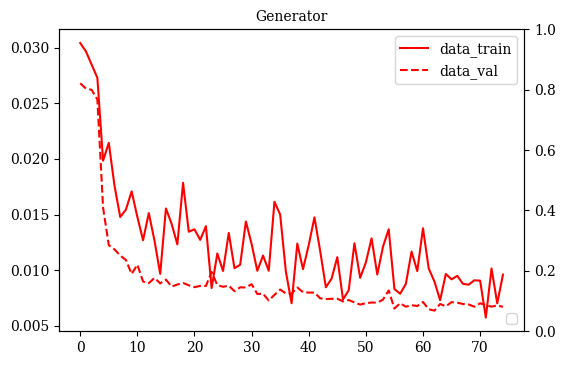

In [22]:
plot_metrics(net.running_metrics_encoder, title='Generator')

## Inference

Structure of data, d:
```0 - syn input
1 - syn low
2 - syn ulow
3 - velocity model
4 - field input
5 - field low
6 - filed ulow
7 - velocity model (zeros)```

### Synthetic

In [23]:
ls_true= dc[1].copy()
hs_true = dc[-1].copy()
print(hs_true.shape)
_, ls_pred, us_pred = net.predict(hs_true)

(1, 324, 376)


0.94615567 0.9454497


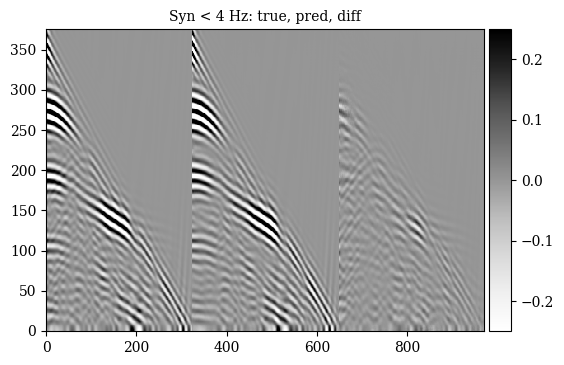

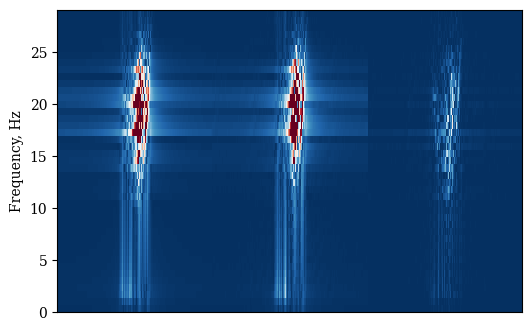

In [24]:
nt_clip=None
vlim_f = {'vmin': -15, 'vmax': 15}
vlim_2f = {'vmin': -0.125, 'vmax': 0.125}
fhp = 0.5
fedge = par['fedge']
dt_net = dt

lst = ls_true[0,...]; ls = ls_pred[0,0,...]
print(lst.max(), ls.max())
lst = ld.bandpass(lst, fs=1/dt_net, flo=fhp, btype='high')
ls = ld.bandpass(ls, fs=1/dt_net, flo=fhp, btype='high')
vis.plot_shot(np.concatenate([lst, ls, lst - ls]), **par_shot_auto,
              title=f'Syn < {_max_freq} Hz: true, pred, diff')
# vis.plot_wiggles([lst[:, :nt_clip], ls[:, :nt_clip]], n=5)

lst_fk, ls_fk = [vis.get_spectrum2(v, dt=dt_net, fmax=7)[0] for v in [lst, ls]]
vis.plot_spectrum2([lst_fk, ls_fk, np.abs(lst_fk-ls_fk)], plot_only=True, pclip=0.25, dt=dt_net)

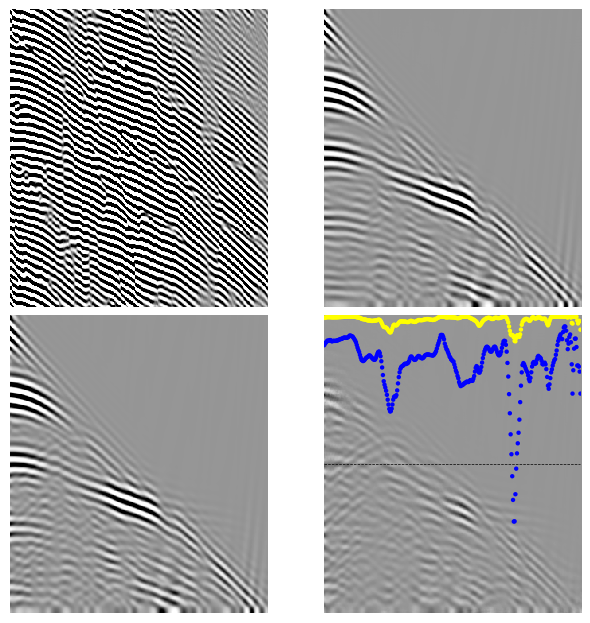

In [25]:
vis.imgrid(hs_true[0,...], lst, [ls], diff_of_diff=False, figsize=(8,8), scatter_size=10, **par_shot_auto)

### Field data

In [36]:
hf_true = df[-1].copy()
lf_true = df[5].copy()
print(hf_true.shape, hf_true.max())
_, lf_pred, uf_pred = net.predict(hf_true)

(1, 324, 376) 52.314766


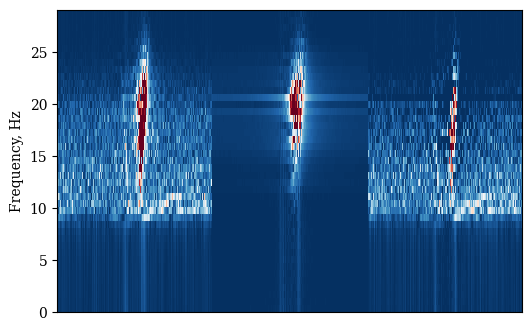

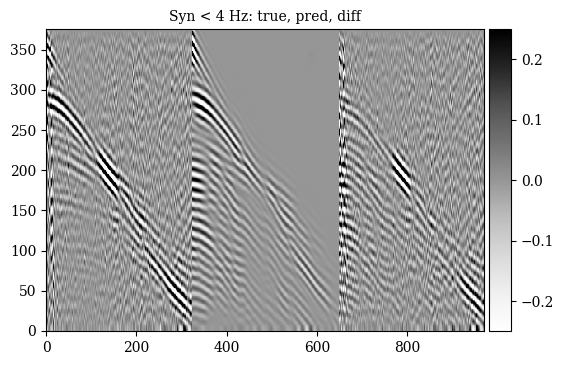

In [41]:
lf = lf_pred.copy()[0, 0,...].astype(np.float32)
lft = lf_true.copy()[0,...]
# lft, lf = [ld.bandpass(v, fhi=3, dt=dt_net, btype='low') for v in [lft, lf]]
lft_fk, lf_fk = [vis.get_spectrum2(v, dt=dt_net, fmax=7)[0] for v in [lft, lf]]
vis.plot_spectrum2([lft_fk, lf_fk, lft_fk-lf_fk], plot_only=True, pclip=0.25, dt=dt_net)
vis.plot_shot(np.concatenate([lft, lf, lft - lf]), **par_shot_auto,
              title=f'Syn < {_max_freq} Hz: true, pred, diff')
# vis.plot_spectra_dict({'known': lft, 'pred': lf}, dt_net, fmax=fedge)

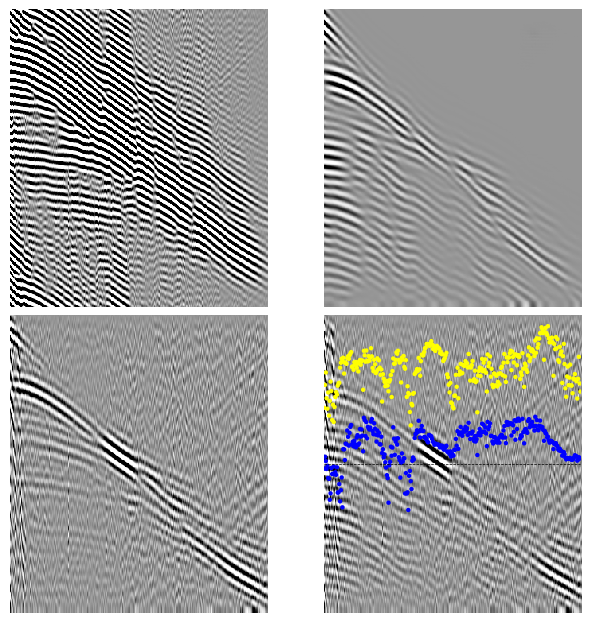

In [42]:
vis.imgrid(hf_true[0,...], lft, [lf], diff_of_diff=False, figsize=(8,8), **par_shot_auto, scatter_size=10)